# 数据预处理部分

In [1]:
# 导入必要的库

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('dark') # 知识点：设置想要的seaborn的风格，避免跟随IDE的风格

import re
import os

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore') # 知识点：过滤掉警告信息，保证输出的整洁
os.chdir('ruc_程序设计大作业/code/data') # 知识点：修改当前工作目录，方便后续读取数据

## 数据预处理

In [2]:
# 读取数据
option_data = pd.read_csv('./raw/option_1d_SH510050.csv') # 知识点：读取数据，./表示当前目录，如果是上一级目录可以用../
index_data = pd.read_csv('./raw/index_1d_SH510050.csv')
calendar_data = pd.read_csv('./raw/calendar.csv')

In [3]:
# 交易日历数据处理
calendar_data['date'] = pd.to_datetime(calendar_data['date'], format='%Y%m%d')
calendar_data['date'] = calendar_data['date'].dt.strftime('%Y-%m-%d') # 知识点：pandas内置的dt对象，转换时间格式
calendar_data['date'] = pd.to_datetime(calendar_data['date'])
calendar_data.head()

,StockID,StockName,date,istradingday
0,SH000001,上证指数,2025-01-02,True
1,SH000001,上证指数,2025-01-03,True
2,SH000001,上证指数,2025-01-06,True
3,SH000001,上证指数,2025-01-07,True
4,SH000001,上证指数,2025-01-08,True


In [4]:
# 标的数据浏览
index_data.head() # 知识点：head()函数展示前5行数据

,datetime,StockID,StockName,close,open,high,low,preclose,volume,amount,cjbs
0,2024-06-13 16:00:00,SH510050,50ETF,2.469,2.448,2.474,2.441,2.452,897068160,2204621312,37788
1,2024-06-16 16:00:00,SH510050,50ETF,2.454,2.453,2.461,2.450,2.469,991137024,2433455872,31368
2,2024-06-17 16:00:00,SH510050,50ETF,2.454,2.453,2.465,2.448,2.454,621849600,1526849024,28480
3,2024-06-18 16:00:00,SH510050,50ETF,2.458,2.455,2.462,2.448,2.454,591825088,1453691648,23864
4,2024-06-19 16:00:00,SH510050,50ETF,2.451,2.455,2.466,2.448,2.458,760900736,1868123776,33044


根据可视化，标的数据需要的预处理有：
1. 按照时间戳（datetime）排序，并对于datetime列，只保留年月日数据（后平移一天）
2. 舍去无用的列（StockID，StockName）
3. 检查量价列的取值是否正常

In [5]:
# 期权数据浏览
option_data.head()

,datetime,code,StockID,StockName,close,open,high,low,preclose,settle,volume,amount,openinterest,openinterest_change
0,2024-04-08 16:00:00,SH510050,OP10006167,50ETF购6月2214A,0.2417,0.2494,0.2495,0.2417,0.2581,0.2432,31.0,78348.42,598,NaN
1,2024-04-08 16:00:00,SH510050,OP10006168,50ETF购6月2264A,0.1970,0.2087,0.2087,0.1970,0.2133,0.1990,16.0,33490.66,1021,NaN
2,2024-04-08 16:00:00,SH510050,OP10006169,50ETF购6月2313A,0.1587,0.1677,0.1677,0.1572,0.1715,0.1585,4.0,6560.96,580,NaN
3,2024-04-08 16:00:00,SH510050,OP10006170,50ETF购6月2362A,0.1221,0.1286,0.1286,0.1219,0.1300,0.1221,119.0,149760.95,1078,NaN
4,2024-04-08 16:00:00,SH510050,OP10006171,50ETF购6月2411A,0.0904,0.0981,0.0985,0.0894,0.0977,0.0904,1023.0,963087.00,1540,NaN


根据可视化，期权数据需要的预处理有：
1. 按照时间戳排序
2. 舍去无用的列（openinterest_change，code，StockID）
3. 从期权合约名称（StockName）中提取合约属性，例如认购/认沽，期限，行权价，及是否受分红影响
4. 检查量价列的取值是否正常

In [6]:
# 考虑到期权和标的数据的处理方式有很多相似之处，我们可以将这些相似之处抽象出来，形成一个类，然后通过继承的方式，分别处理期权和标的数据

# 预处理基类
class preprocess:
    def __init__(self):
        pass

    def datetime_handle(self, data):
        # 按照时间戳（datetime）排序
        data['datetime'] = pd.to_datetime(data['datetime'])
        data.sort_values('datetime', inplace=True)
        data.reset_index(drop=True, inplace=True)
        # 只保留年月日
        data['datetime'] = data['datetime'].dt.strftime('%Y-%m-%d') # 知识点：使用pandas自带的dt.strftime()函数，匹配需要的时间格式（这里是年月日）
        data['datetime'] = pd.to_datetime(data['datetime']) + pd.DateOffset(days=1) # 知识点：使用pd.DateOffset()函数，对时间进行运算（平移）
        return data
    
    def drop_columns(self, data, cols):
        data.drop(cols, axis=1, inplace=True)
        return data
    
    def check_pricing_columns(self, data):

        # 知识点：assert断言，用于判断某个条件是否满足，如果不满足则抛出异常，一般用于对代码/数据进行检查，确保其正确性

        assert data['close'].min() >= 0
        assert data['open'].min() >= 0
        assert data['high'].min() >= 0
        assert data['low'].min() >= 0
        assert data['preclose'].min() >= 0
        assert data['volume'].min() >= 0
        assert data['amount'].min() >= 0

        return data

# 期权预处理类
class option_preprocess(preprocess): # 知识点：通过类（class）的继承，可以将父类的方法和属性传递给子类，进而实现代码的复用
    def __init__(self):
        self.r = 0.025
    
    def extract_from_stockname(self, data):

        formula = r'(\d{2}ETF)(购|沽)(\d{1,2})月(\d{4})(A|B|C)?' # （*）知识点：正则表达式，用于匹配字符串，这里用于从期权合约名称中提取合约属性

        def parse_stockname(stockname): 
            match = re.match(formula, stockname)
            if match:
                etf_name = match.group(1)
                option_type = match.group(2)
                expiration = int(match.group(3))
                strike_price = float(match.group(4)) / 1000
                dividend_impact = 1 if match.group(5) else 0
                return pd.Series([option_type, expiration, strike_price, dividend_impact])
            else:
                return pd.Series([None, None, None, None])

        data[['option_type', 'expiration_month', 'strike_price', 'dividend_impact']] = data['StockName'].apply(parse_stockname) # 知识点：apply函数，对dataframe的某一列进行函数映射
        
        return data
    
    def handle_expire_date(self, data):
        cur_date = data['datetime'].values[0]
        cur_date = pd.to_datetime(cur_date) 
        cur_month = cur_date.month
        cur_year = cur_date.year

        expire_month = data['expiration_month'].values[0]        
        if cur_month > expire_month:
            expire_year = cur_year + 1
        else:
            expire_year = cur_year
        first_day_of_expire_month = datetime(expire_year, expire_month, 1)
        first_wednesday = first_day_of_expire_month + timedelta(days=(2 - first_day_of_expire_month.weekday() + 7) % 7) # 知识点：datetime模块，timedelta函数，计算第一个周三的日期
        expire_date = first_wednesday + timedelta(weeks=3)
        data['expire_date'] = expire_date
        return data
        
    def compute_trading_days_to_expiration(self, data, calender):

        calender['date'] = pd.to_datetime(calender['date'])
        data['datetime'] = pd.to_datetime(data['datetime'])
        data['expire_date'] = pd.to_datetime(data['expire_date'])

        trading_days_dict = {} # （*）知识点： 矢量化计算，避免使用循环，这里利用字典进行缓存，以避免重复计算，极大提高了计算效率
        
        # 计算到期日前的交易日天数
        def get_trading_days(start_date, end_date):
            if (start_date, end_date) in trading_days_dict:
                return trading_days_dict[(start_date, end_date)]
            trading_days = calender[(calender['date'] >= start_date) & (calender['date'] <= end_date)].shape[0]
            trading_days_dict[(start_date, end_date)] = trading_days
            return trading_days
        
        data['trading_days_to_expiration'] = data.apply(
            lambda row: get_trading_days(row['datetime'], row['expire_date']),
            axis=1
        )

        return data


    def compute_expiration_order(self, data): # 计算期权合约的期限顺序
        data['expiration_order'] = data.groupby(['option_type','datetime', 'strike_price'])['trading_days_to_expiration']\
            .rank(ascending=True, method='dense') - 1 # 知识点：groupby函数和rank函数的嵌套使用，实现了对数据的分组和排序
        return data
    
    def compute_strike_price_order(self, data, und): # 计算期权合约的行权价顺序
        '''
        输入：某日，某期限下的期权合约数据
        输出：将行权价顺序输出到df中的一列，输出总的df
        '''
        und_price = und[und['datetime'] == data['datetime'].values[0]]['close'].values[0]
        maturity = data['trading_days_to_expiration'].values[0]
        fwd_price = und_price * np.exp(self.r * maturity / 252) # 知识点：np.exp()函数，计算e的x次方，这里是计算未来价格贴现

        call = data[data['option_type'] == '购']
        put = data[data['option_type'] == '沽']

        call_strike_list = call['strike_price'].unique().tolist() # 知识点：unique函数，去重，得到唯一值
        put_strike_list = put['strike_price'].unique().tolist()
        call_strike_list.sort() 
        put_strike_list.sort(reverse=True) # 知识点：sort函数，对列表进行排序，默认升序

        c_atm_strike = min(call_strike_list, key=lambda x:abs(x-fwd_price)) # 知识点：lambda函数和min函数的嵌套使用，用较少的代码实现了一种功能
        p_atm_strike = min(put_strike_list, key=lambda x:abs(x-fwd_price))
        assert c_atm_strike == p_atm_strike
        c_atm_strike_index = call_strike_list.index(c_atm_strike)
        p_atm_strike_index = put_strike_list.index(p_atm_strike)

        call['strike_price_order'] = call['strike_price'].apply(lambda x: call_strike_list.index(x) - c_atm_strike_index)
        put['strike_price_order'] = put['strike_price'].apply(lambda x: put_strike_list.index(x) - p_atm_strike_index)

        data = pd.concat([call, put], axis=0) # 知识点：concat函数，dataframe的拼接函数，axis=0表示按行拼接
        
        return data
        
    def option_characteristics(self, data, index_data, calendar_data):
        '''
        从期权合约名称（StockName）中提取合约属性，例如认购/认沽，期限，行权价，及是否受分红影响

        例如：50ETF购6月2214A
        认购/认沽：购
        期限：6月
        期限顺序：近月（0）、次近月（1）、……
        行权价：2.214
        行权价顺序：
        '''
        data = self.datetime_handle(data)
        data = self.drop_columns(data, ['StockID', 'code', 'openinterest_change'])
        data = self.extract_from_stockname(data)
        data = data.groupby(['datetime', 'expiration_month']).apply(self.handle_expire_date).reset_index(drop=True)
        data = self.compute_trading_days_to_expiration(data, calendar_data)
        data = self.compute_expiration_order(data)
        data = data.groupby(['datetime', 'expire_date']).apply(self.compute_strike_price_order, index_data).reset_index(drop=True)
        data = self.check_pricing_columns(data)
        return data
    
# 标的预处理类
class index_preprocess(preprocess):
    def __init__(self):
        pass
    
    def index_characteristics(self, data):
        '''
        处理标的数据
        '''
        data = self.datetime_handle(data)
        data = self.drop_columns(data, ['StockID', 'StockName'])
        data = self.check_pricing_columns(data)
        return data

In [7]:
index_data = index_preprocess().index_characteristics(index_data) # 知识点：类的实例化，通过类的实例化，可以调用类的方法
option_data = option_preprocess().option_characteristics(option_data, index_data, calendar_data)

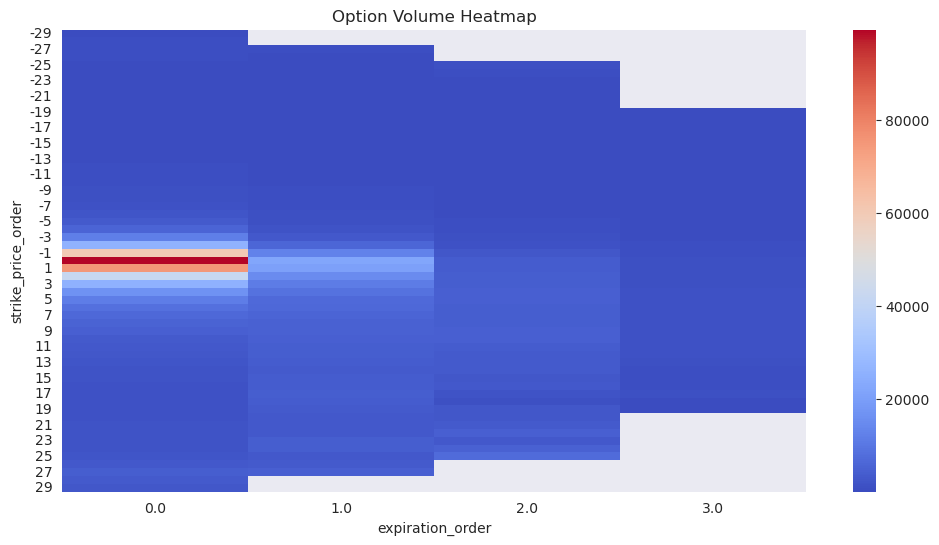

In [8]:
# 流动性比较-成交量
plt.figure(figsize=(12, 6))
# 横轴为strike_price_order，纵轴为expiration_order，颜色深浅表示成交量
sns.heatmap(option_data.groupby(['strike_price_order', 'expiration_order'])['volume'].mean().unstack(), cmap='coolwarm')
plt.title('Option Volume Heatmap')
plt.show()